In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import copy
import matplotlib
%matplotlib inline
sys.path.append("..")
from demo_2_awac import och_2_awac
import adept_envs
import gym
env = gym.make("franka_microwave_cabinet_slider_resetfree-v1")

# all_paths = ['../../../sim_franka/rpl_reset_free/recordings/play_segmented_CS.pkl',]
             
all_paths = ['/usr/local/google/home/abhishekunique/sim_franka/simplified_awac/recordings/recording.pkl']
dat = []

for p in all_paths:
    dat_curr = pickle.load(open(p, 'rb'))
    dat += dat_curr
print(len(dat))


40


In [2]:
list_awac = och_2_awac(dat)
print(list_awac[0]['observations'].shape)

(242, 19)


(242, 19)


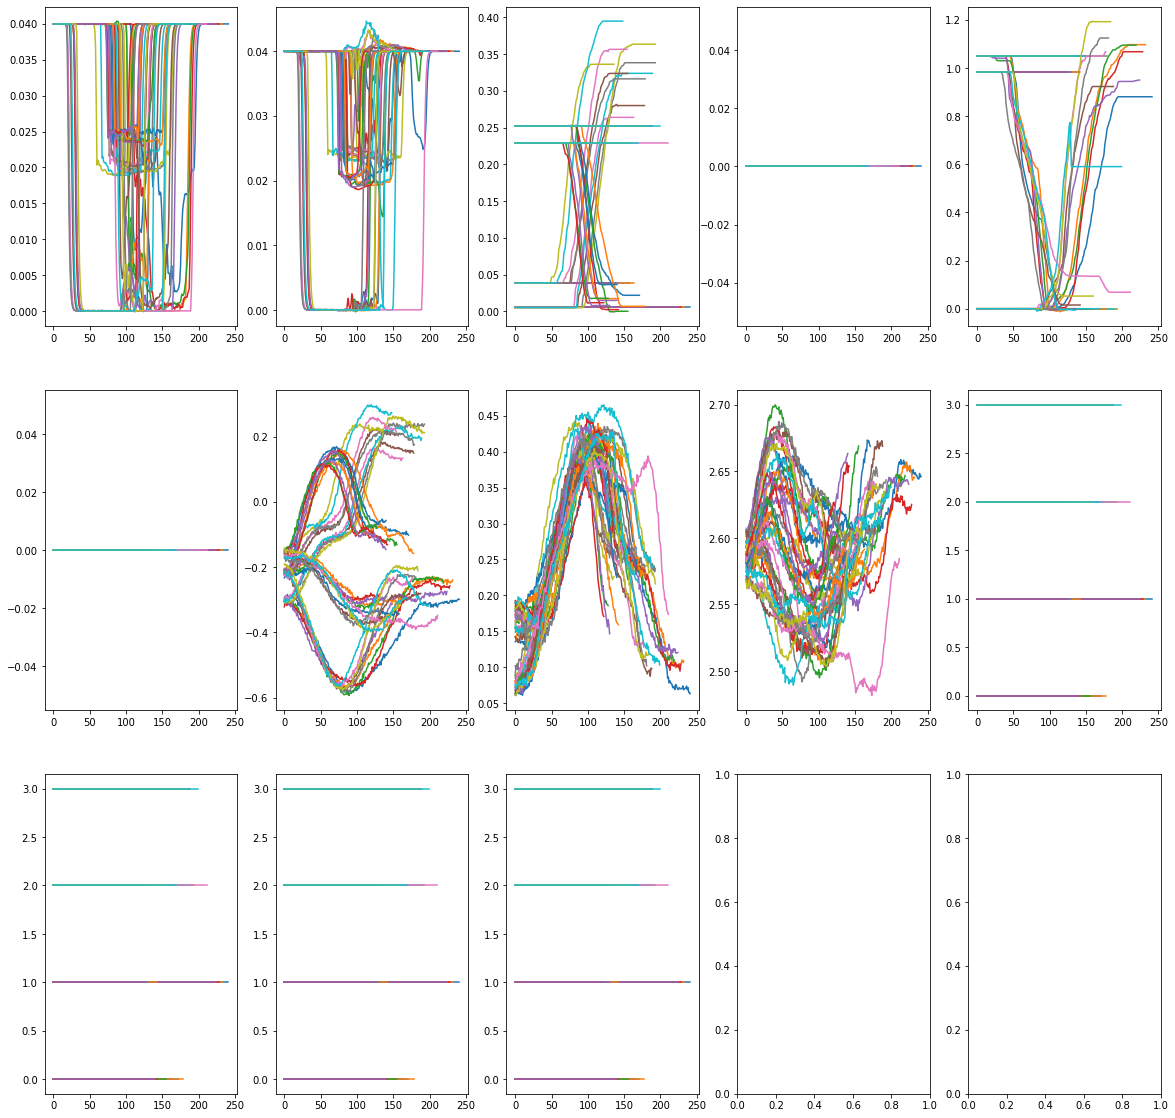

In [3]:
print(list_awac[0]['observations'].shape)
curr_x = 0
fig, ax = plt.subplots(3, 5, figsize=(20, 20))
for p in list_awac:
    for i in range(3):  
        for j in range(5):
            if i*5 + j == 13:
                break
            if i*5 +j == 1: 
                ax[i][j].plot(range(curr_x, curr_x + len(p['observations'])), p['observations'][:, i*5 + j])
            else:
                ax[i][j].plot(range(curr_x, curr_x + len(p['observations'])), p['observations'][:, i*5 + j])

plt.show()

(242, 19)
(233, 19)
(220, 19)
(229, 19)
(225, 19)
(179, 19)
(164, 19)
(194, 19)
(194, 19)
(190, 19)
(159, 19)
(164, 19)
(138, 19)
(132, 19)
(142, 19)
(156, 19)
(155, 19)
(180, 19)
(137, 19)
(149, 19)
(172, 19)
(179, 19)
(156, 19)
(143, 19)
(141, 19)
(189, 19)
(178, 19)
(182, 19)
(185, 19)
(200, 19)
(141, 19)
(143, 19)
(129, 19)
(123, 19)
(131, 19)
(143, 19)
(212, 19)
(131, 19)
(161, 19)
(170, 19)


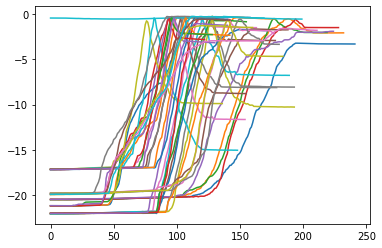

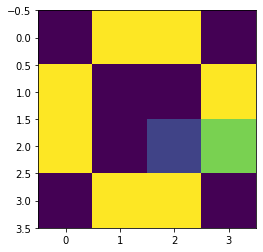

In [4]:
import itertools
def check_goal_completion(curr_pos):
    max_objs = np.array([0.17, 0.6])
    min_objs = np.array([0.08, 0.2])
    init_bitflips = np.array([0, 0])
    curr_bitflips = init_bitflips.copy()
    for j, pos_idx in enumerate([0, 2]):
        if curr_pos[pos_idx] > max_objs[j]:
            curr_bitflips[j] = 1
        elif curr_pos[pos_idx] < min_objs[j]:
            curr_bitflips[j] = 0
    new_idx = 2*curr_bitflips[0] + curr_bitflips[1]
    return new_idx

idx_completion = False
def end_relabel(env, path):
    o_size = 9
#     path['observations'][:, o_size:] = path['observations'][-1, :o_size].copy()
#     path['next_observations'][:, o_size:] = path['observations'][-1, :o_size]
    env.env.goal_idx = check_goal_completion(path['observations'][-1, 2:6])
    env.env.current_idx = check_goal_completion(path['observations'][0, 2:6])
    concat_val = np.ones((path['observations'].shape[0], 10))*env.env.goal_idx
    path['observations'] = np.concatenate([path['observations'][:, :o_size], concat_val], axis=-1)
    path['next_observations'] = np.concatenate([path['next_observations'][:, :o_size], concat_val], axis=-1)
    env.env.goal = path['observations'][-1, :o_size].copy()
    env.env._idx_completion = idx_completion
    path['rewards'] = np.zeros_like(path['rewards'])
    for idx in range(len(path['observations'])):
        reward_dict = env.env.get_reward_dict(None, {'obj_qp': path['observations'][idx:idx+1, 2:6],
                                                     'mocap_pos': path['observations'][idx:idx+1, 6:9]})
        path['rewards'][idx] = np.sum([v for k, v in reward_dict.items()])
    return path


list_awac = och_2_awac(dat)
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt 
curr_x = 0  
label_list = itertools.product(['SC', 'SO'], ['CC', 'CO'])
tasks = ['-'.join(s) for s in label_list]
# tasks = ['CC', 'CO', 'OC', 'OO']
task_list = []
adjacency_matrix = np.zeros((4, 4))
labeled_goals = [[] for _ in range(4)]
counts_starts = np.zeros(4)
counts_goals = np.zeros(4)
end_states_val = [None for _ in range(4)]
end_states = [None for _ in range(4)]

path_lists = [[[] for _ in range(4)] for _ in range(4)]

for i, path in enumerate(list_awac):
    end_relabel(env, path)
    print(path['observations'].shape)
    plt.plot(path['rewards'])
plt.show()
    
for p in list_awac:
    curr_x += len(p['observations'])
    start_idx = check_goal_completion(p['observations'][0, 2:6])
    start = tasks[start_idx]
    end_idx = check_goal_completion(p['observations'][-1, 2:6])
    end = tasks[end_idx]
    adjacency_matrix[start_idx, end_idx] += 1
    path_lists[start_idx][end_idx].append(copy.deepcopy(p))
    task_list.append(check_goal_completion(p['observations'][-1, 2:6]))
    labeled_goals[end_idx].append(p['observations'][-1])
    counts_goals[end_idx] += 1
    counts_starts[start_idx] += 1
    if end_states_val[end_idx] is None:
        end_states_val[end_idx] = p['observations'][-1, :13]
        end_states[end_idx] = np.ones(10)*end_idx
plt.show() 

plt.imshow(adjacency_matrix)
plt.show()

In [ ]:
for path in list_awac:
    mocap_poss = []
    for i in range(path['observations'].shape[0]):
        nmp = path['observations'][i, 6:9] + path['actions'][i, :3]*env.env.range
        nmp = np.clip(nmp, env.env.mocap_pos_clip_lower, env.env.mocap_pos_clip_upper)
        meanval = (env.env.mocap_pos_clip_upper + env.env.mocap_pos_clip_lower)/2.0
        rng = (env.env.mocap_pos_clip_upper - env.env.mocap_pos_clip_lower)/2.0
        nmp = (nmp - meanval)/rng
        mocap_poss.append(nmp)
    mocap_poss = np.array(mocap_poss)
    mocap_poss = np.concatenate([path['actions'][:, :3], path['actions'][:, -2:]], axis=-1)
    path['actions'] = mocap_poss
    #print(path['actions'].shape)
fig,  ax = plt.subplots(5, figsize=(20, 20))
for p in list_awac:
    for i in range(5):  
        ax[i].plot(p['actions'][:, i])
plt.show()

In [ ]:
pickle.dump(list_awac, open('demo_list_2elements_deltapos_noredundancy_smallernoise_rewardfixed.pkl', 'wb'))